https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
def str_to_datetime(s):
    split_temp = s.split(' ')
    date = split_temp[0].split('/')
    time = []
    time.append(split_temp[1][0:2])
    time.append(split_temp[1][3:5])
    time.append(split_temp[1][6:8])
    year, month, day = int('20' + date[0]), int(date[1]), int(date[2])
    hour, minutes, seconds = int(time[0]), int(time[1]), int(time[2])
    return datetime.datetime(year=year, month=month, day=day, hour=hour,minute=minutes,second=seconds)

In [3]:
df = pd.read_csv('ticket data.csv',index_col=0)
df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')
df.index = pd.DatetimeIndex(df.index).to_period(freq='H')
df = df[:-6]
df.head()

,Count
Date,
2022-07-01 00:00,362
2022-07-01 01:00,486
2022-07-01 02:00,363
2022-07-01 03:00,225
2022-07-01 04:00,116


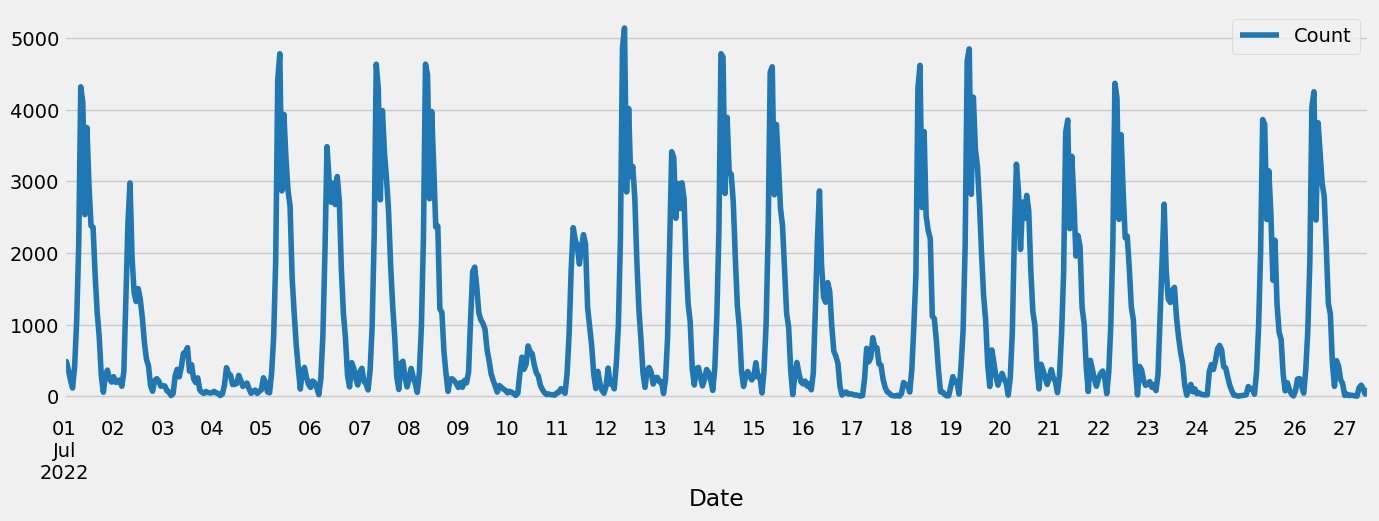

In [4]:
df.plot(style='-',
        figsize=(15, 5),
        color=color_pal[0]
       )
plt.show()

In [5]:
print(df.shape)
train=df.iloc[:-163]
test=df.iloc[-163:]
print(train.shape,test.shape)

(631, 1)
(468, 1) (163, 1)


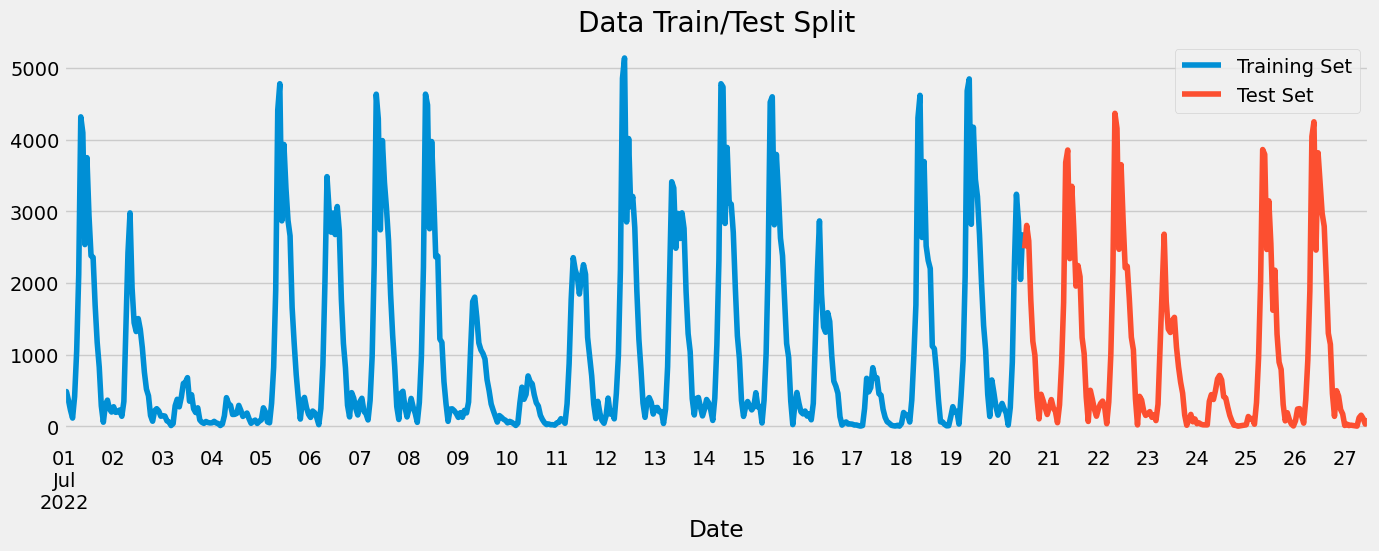

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [7]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    #df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [8]:
df

,Count,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
Date,,,,,,,,
2022-07-01 00:00,362,0,4,3,7,2022,182,1
2022-07-01 01:00,486,1,4,3,7,2022,182,1
2022-07-01 02:00,363,2,4,3,7,2022,182,1
2022-07-01 03:00,225,3,4,3,7,2022,182,1
2022-07-01 04:00,116,4,4,3,7,2022,182,1
...,...,...,...,...,...,...,...,...
2022-07-27 08:00,156,8,2,3,7,2022,208,27
2022-07-27 09:00,108,9,2,3,7,2022,208,27
2022-07-27 10:00,32,10,2,3,7,2022,208,27


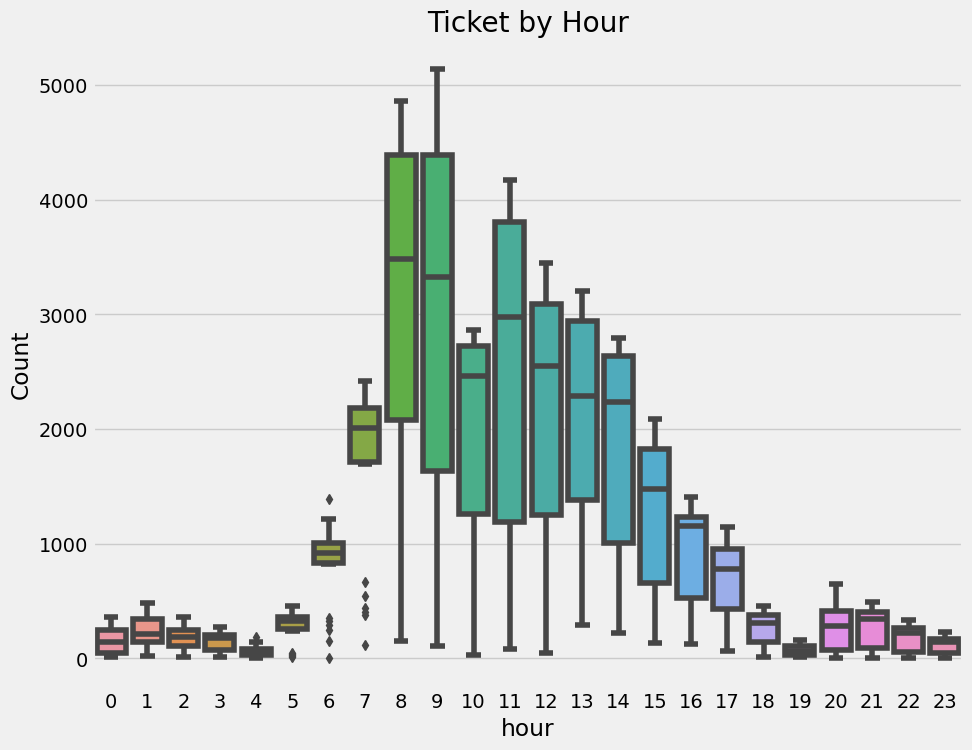

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Count')
ax.set_title('Ticket by Hour')
plt.show()

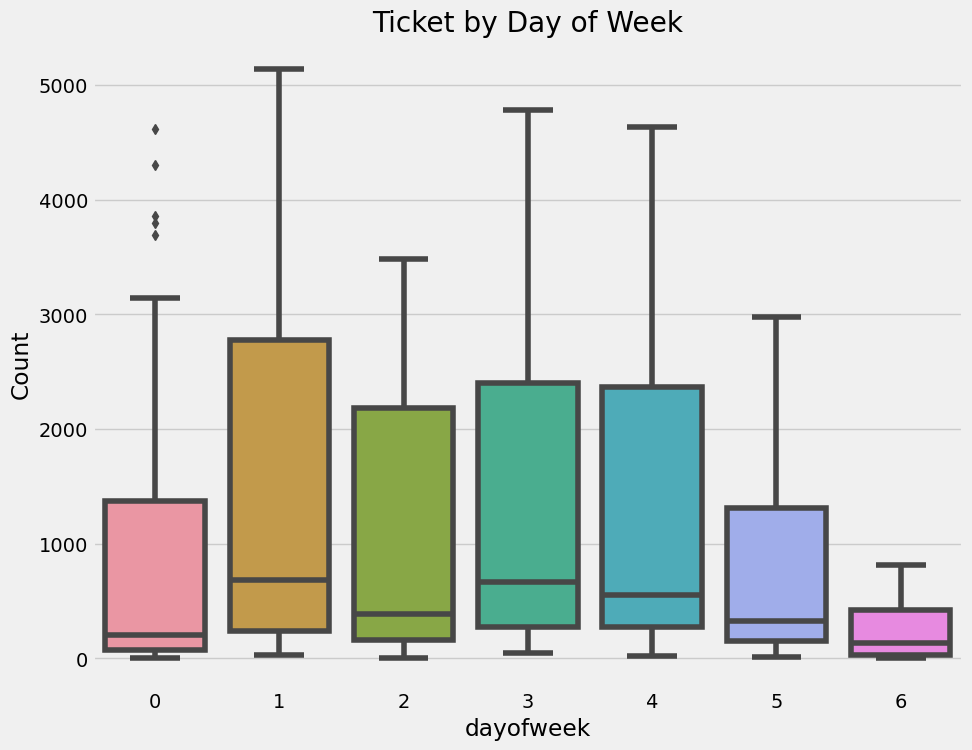

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='Count')
ax.set_title('Ticket by Day of Week')
plt.show()

In [11]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Count'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [12]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[14:53:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1597.78844	validation_1-rmse:1509.87403
[100]	validation_0-rmse:810.23533	validation_1-rmse:764.18357
[200]	validation_0-rmse:548.08818	validation_1-rmse:627.09674
[296]	validation_0-rmse:438.68246	validation_1-rmse:623.88729


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

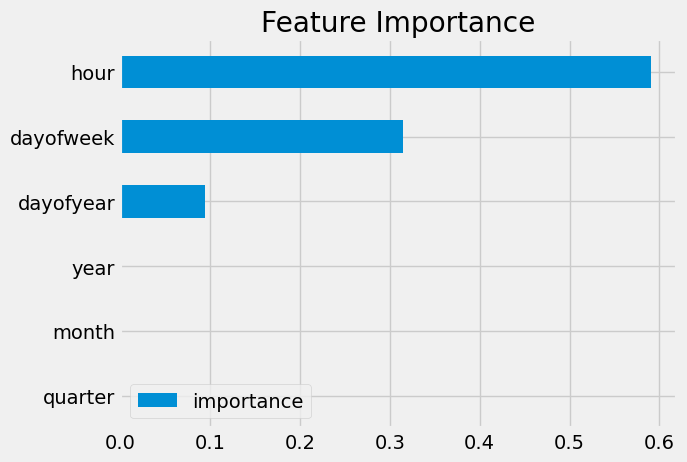

In [13]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

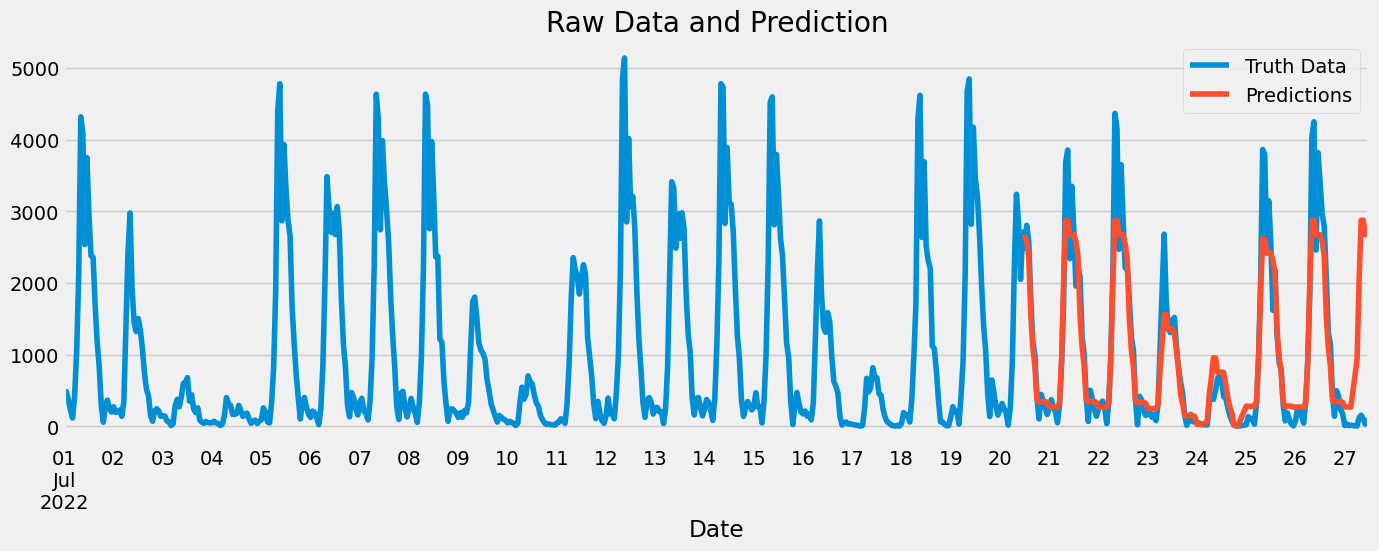

In [14]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Count']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

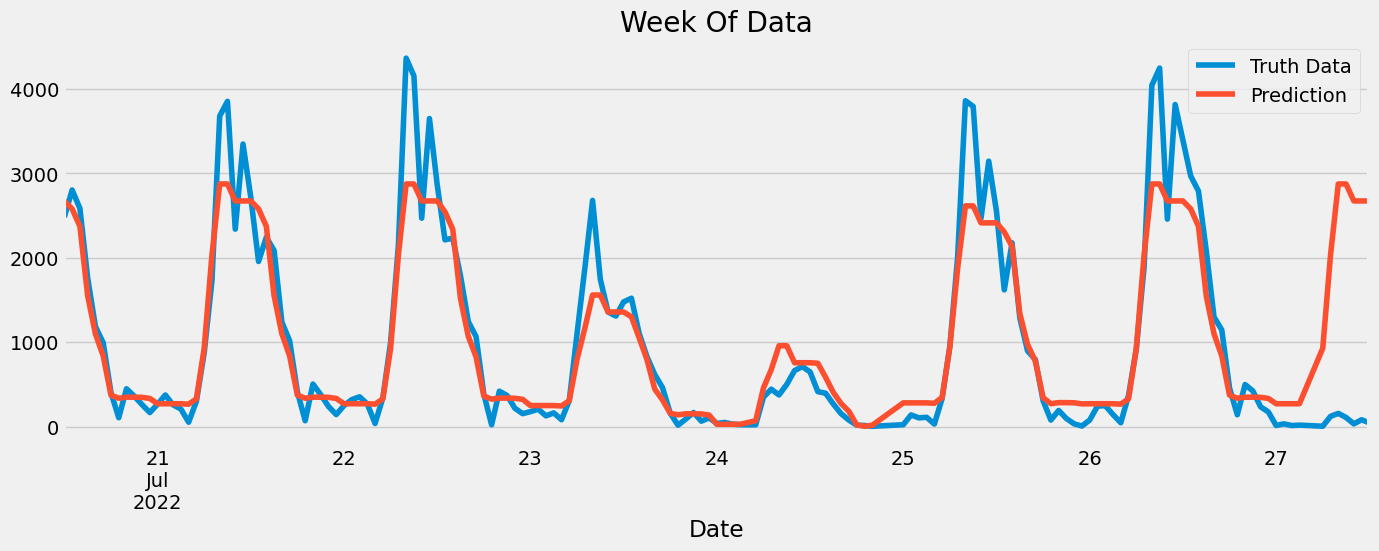

In [15]:
ax = df[-163:]['Count'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df[-163:]['prediction'] \
    .plot(style='-')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [16]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index
test.groupby(['date'])['error'].mean()

date
2022-07-20 12:00     191.371826
2022-07-20 13:00     224.146729
2022-07-20 14:00     212.114258
2022-07-20 15:00     211.796387
2022-07-20 16:00      84.499512
                       ...     
2022-07-27 08:00    2719.611328
2022-07-27 09:00    2767.611328
2022-07-27 10:00    2642.371826
2022-07-27 11:00    2593.371826
2022-07-27 12:00    2630.371826
Freq: H, Name: error, Length: 163, dtype: float64